In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import numpy as np
import math


#---------------------------------------------------
#--------------0 = A,B,C,D Pareto Optimal
#--------------1 = A,B,C Pareto Optimal
#--------------2 = A,C Pareto Optimal


p = 0.02
W = int(1/p)+1
tau = np.hstack([np.arange(0.0, 2.0, 0.01),np.arange(2.0, 10.0, 0.01),np.arange(10,100,2), np.arange(100,500,5)])
N_tau = np.size(tau)
epsilon = np.arange(21)*0.05
epsilon = np.around(epsilon, decimals = 3)
N_eps = np.size(epsilon)
REWARDS = np.array([0,4,9,10])
THREATS = np.array([0,-1,-4,-10])

def softmax(R,T):
    P = np.zeros((W,N_tau,4))
    for n in range(N_tau):
        for w in range(W):
            weight = [w*p, 1.0-w*p]
            temp = (weight[0]*R + weight[1]*T)*tau[n]
            temp = temp - np.max(temp)
            P[w,n,:] = np.exp(temp)/np.sum(np.exp(temp))
    learner = "Softmax One"
    return P, learner

def selective_attention(R,T):
    P = np.zeros((W,N_tau,4))
    for n in range(N_tau):
        ex_R = np.exp((R - np.max(R))*tau[n])
        ex_T = np.exp((T - np.max(T))*tau[n])
        weight_R = ex_R/np.sum(ex_R)
        weight_T = ex_T/np.sum(ex_T)
        for w in range(W):
            weight = [w*p,1.0-w*p]
            P[w,n,:] = weight[0]*weight_R + weight[1]*weight_T
    learner = "Softmax Two"
    return np.round(P,3), learner

def eps_greedy(R,T):
    P = np.zeros((W,N_eps,4))
    temp = np.zeros(4)
    for n in range(N_eps):
        for w in range(W):
            weight = [w*p, 1-w*p]
            for i in range(4):
                temp[i] = weight[0]*R[i] + weight[1]*T[i]
            k = np.argmax(temp)
            for i in range(4):
                if i == k:
                    P[w,n,i] = 1-0.75*epsilon[n]
                else:
                    P[w,n,i] = 0.25*epsilon[n]
    
    learner = "Epsilon-Greedy"
    return P, learner

#---- this only runs the selected decision_maker-------------
def run(decision_maker, R,T):
    if decision_maker!=eps_greedy:
        reward = np.zeros((W,N_tau))
        threat = np.zeros((W,N_tau))
        prob, learner_type = decision_maker(R,T)
        for w in range(W):
            for n in range(N_tau):
                reward[w,n] = np.dot(prob[w,n], R)
                threat[w,n] = np.dot(prob[w,n], T)
    else:
        reward = np.zeros((W,N_eps))
        threat = np.zeros((W,N_eps))
        prob, learner_type = decision_maker(R,T)
        for w in range(W):
            for n in range(N_eps):
                reward[w,n] = np.dot(prob[w,n], R)
                threat[w,n] = np.dot(prob[w,n], T)        
    return threat, reward

def rotate(x, y, theta):
    L = len(x)
    p = np.array([x,y])
    #print(p)
    xx = np.mean(x)
    yy = np.mean(y)
    m = np.zeros((2,L))
    for l in range(L):
        m[0,l] = xx
        m[1,l] = yy
    #print(m)
    rot_matrix = np.array([[math.cos(theta), - math.sin(theta)],
                         [math.sin(theta), math.cos(theta)]])
    rotated = np.dot(rot_matrix, np.array([x,y]) - m) + m
    return rotated
# given a single value of t = tau and w solver
def sa_solver(R, T, w, tau):
    R_den = R*tau - np.max(R*tau)
    T_den = T*tau - np.max(T*tau)
    R_plus = np.exp(R_den)/np.sum(np.exp(R_den))
    T_plus = np.exp(T_den)/np.sum(np.exp(T_den))
    temp = w*R_plus +(1-w)*T_plus
    y_value = np.dot(temp, R)
    x_value = np.dot(temp, T)
    return x_value, y_value

(4,) (4,)
(2252,)


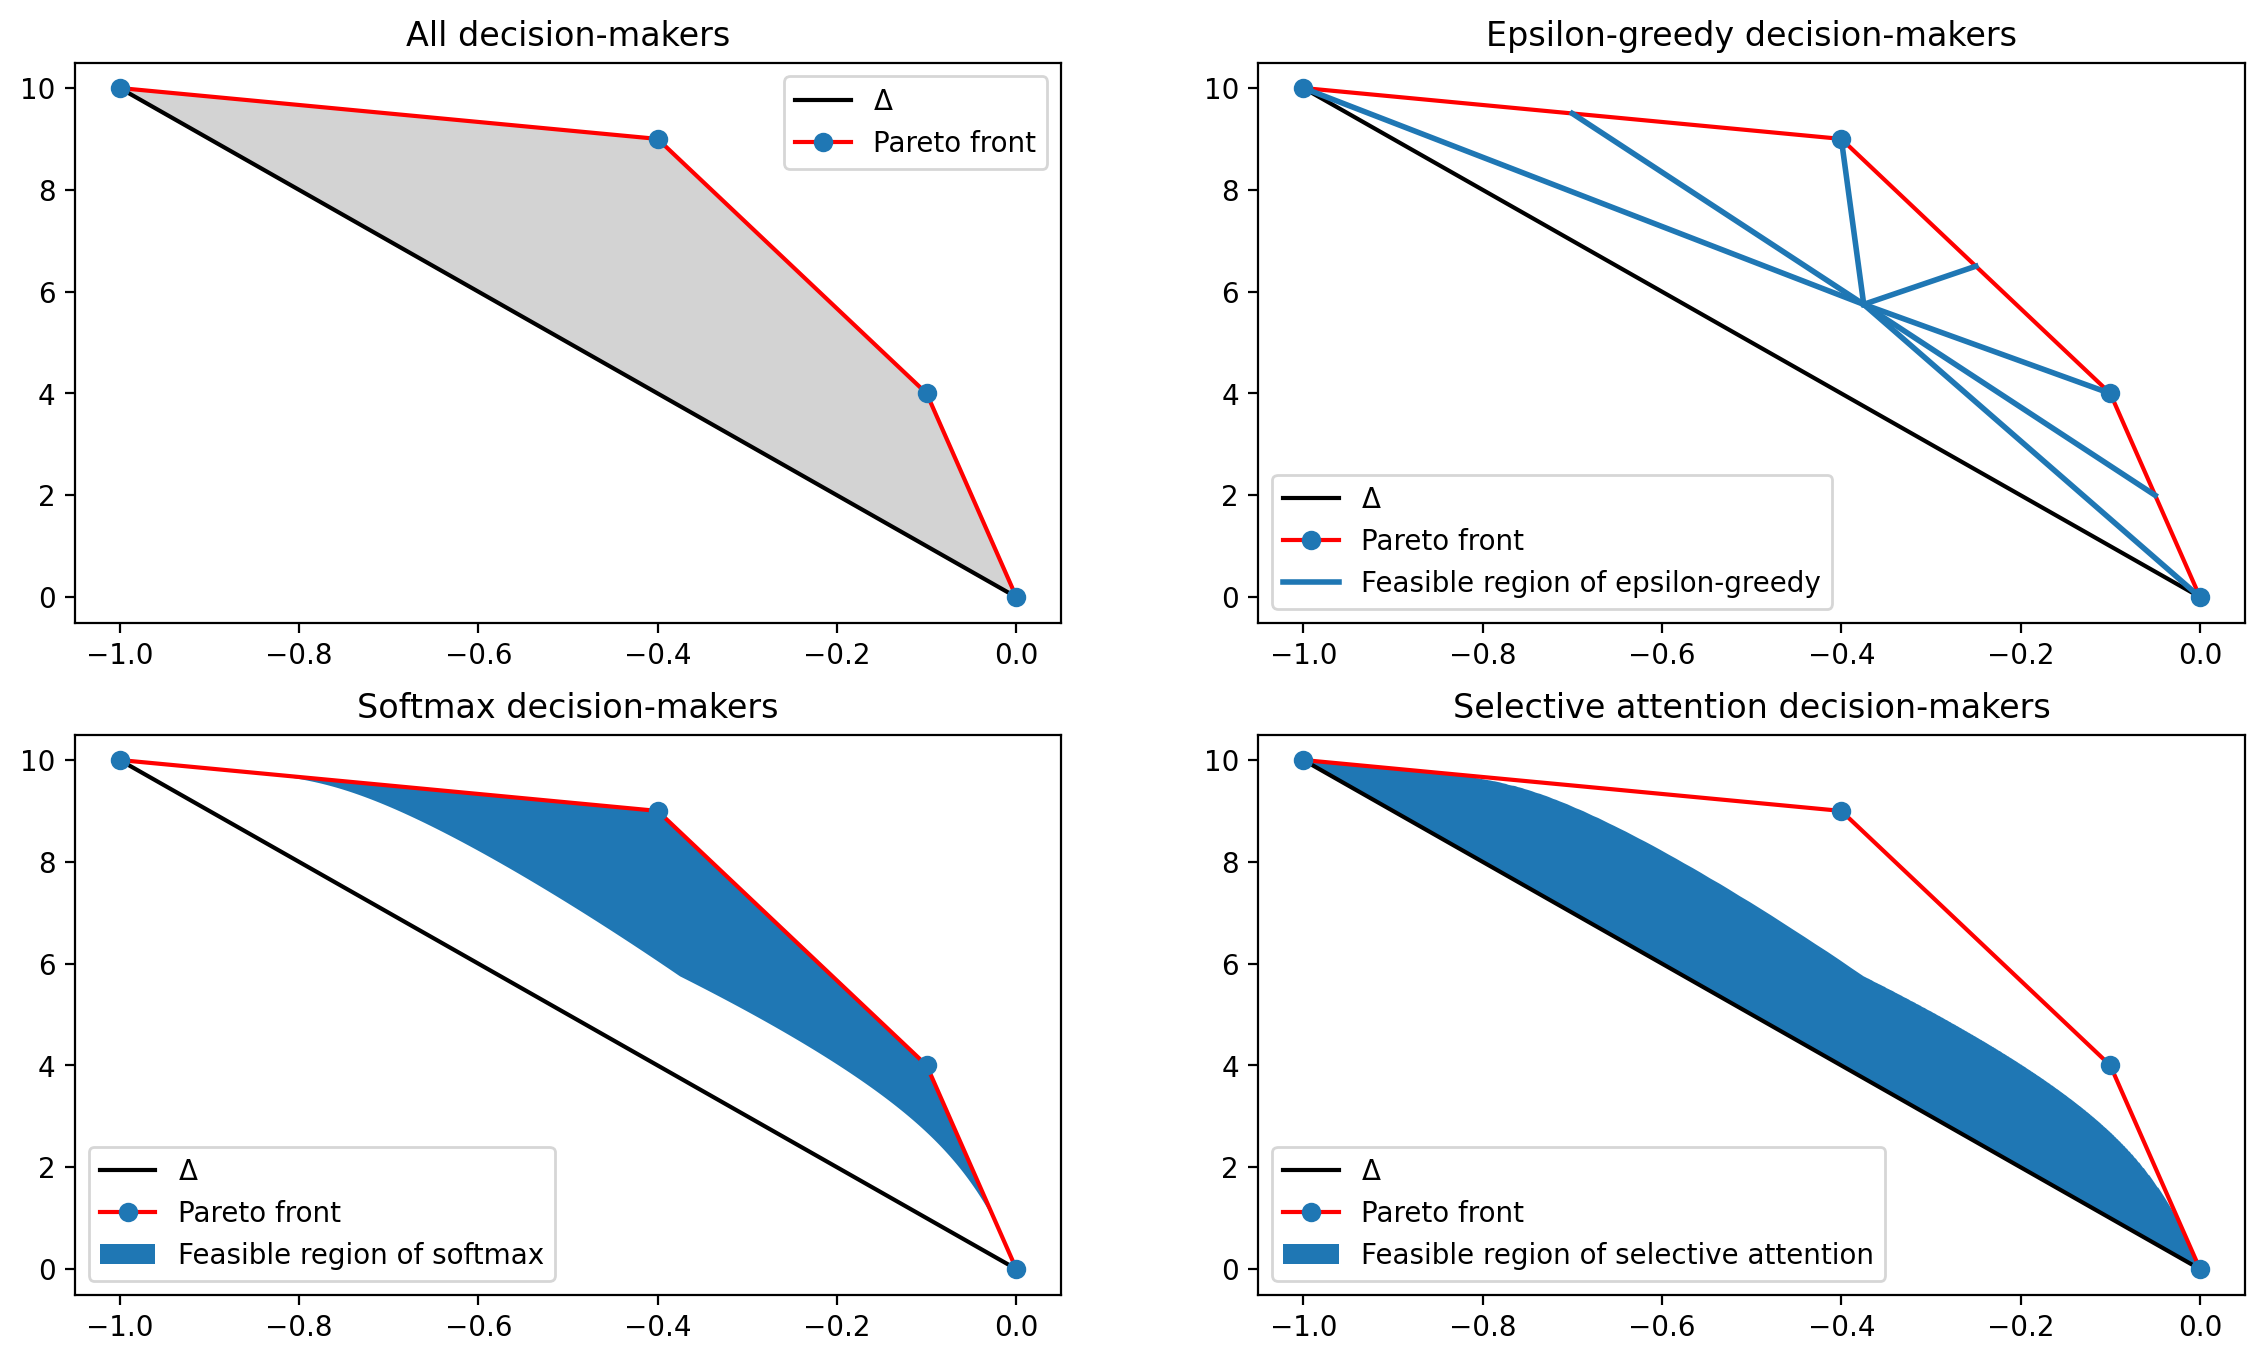

In [2]:
# Figure 5 in Chapter 4. Shows a non-trivial feasible space and the decision-makers' feasible regions. 
figure(figsize=(14, 8), dpi=200)
R = REWARDS
T = THREATS
T=T/np.max(-T)
decision_maker = [eps_greedy, selective_attention, softmax]
#-------An example of non-trivial Feasible Space-----------
plt.figure(1)
plt.subplot(2,2,1)
plt.plot([T[0], T[3]], [R[0], R[3]], color = 'black' )
plt.plot(T,R, color = 'red', marker = 'o', markerfacecolor = '#1f77b4', markeredgecolor = '#1f77b4')
# filling with shade using pyplot fill_between
x,y = T,R
y1 = y
y2 = [y[0]]
m = (y[3] - y[0])/(x[3] - x[0])
b = (y[0]*x[3] - y[3]*x[0])/(x[3] - x[0])

y2.append(m*x[1]+b)
y2.append(m*x[2]+b)
y2.append(y[3])
print(np.shape(y1), np.shape(y2))

plt.fill_between(x,y1,y2, color = 'lightgrey')

plt.title("All decision-makers")
plt.legend(['$\Delta$', 'Pareto front'])


#------Epsilon Greedy Feasible Region---------------
plt.subplot(2,2,2)
plt.plot([T[0], T[3]], [R[0], R[3]], color = 'black')
plt.plot(T,R, marker = 'o', color = 'red', markerfacecolor = '#1f77b4', markeredgecolor = '#1f77b4')
x,y = run(eps_greedy,R,T)
centroid =[np.mean(T), np.mean(R)]
for i in range(4):
    plt.plot([centroid[0], T[i]], [centroid[1], R[i]],c='#1f77b4', linewidth = 2)

for i in range(3):
    plt.plot([centroid[0], (T[i]+T[i+1])*0.5],[centroid[1], (R[i]+R[i+1])*0.5], c='#1f77b4', linewidth = 2)
plt.title("Epsilon-greedy decision-makers")
plt.legend(['$\Delta$', 'Pareto front',  'Feasible region of epsilon-greedy'])

#--------------Softmax Feasible Region--------------
plt.subplot(2,2,3)
plt.plot([T[0], T[3]], [R[0], R[3]], color = 'black')


x,y = run(softmax,R,T)
centroid =[np.mean(T), np.mean(R)]

#-fil_between takes some work here---
X = np.hstack([x[0], x[-1], T[3], T[0]])
Y = np.hstack([y[0], y[-1], R[3], R[0]])
X1 = np.argsort(X)
X = X[X1]
Y1= Y[X1] # y coordinate now sorted for the w = 0,1 boundaries
Y2 = [] # this is for the Pareto Front
m = np.zeros(3) # slopes of three line segments
b = np.zeros(3) # intercepts of three line segments
for i in range(0,3):
    m[2-i] = (R[3-i] - R[2-i])/(T[3-i] - T[2-i])
    b[2-i] = R[3-i] - m[2-i]*T[3-i]
id = 0

for i in range(0,3):
    while(X[id] < T[2-i]):
        Y2.append(m[2-i]*X[id]+b[2-i])
        id+=1
Y2.append(R[0])
print(np.shape(Y2))
plt.plot(T,R,color = 'red',marker = 'o', markerfacecolor = '#1f77b4', markeredgecolor = '#1f77b4')
plt.fill_between(X,Y1,Y2)

plt.title("Softmax decision-makers")
plt.legend(['$\Delta$', 'Pareto front', 'Feasible region of softmax'])

#---------------------Selective Attention Feasible Region-----------------------
plt.subplot(2,2,4)
plt.plot([T[0], T[3]], [R[0], R[3]], color = 'black')

x,y = run(selective_attention,R,T)
centroid =[np.mean(T), np.mean(R)]
#plt.plot(x[0], y[0])
#plt.plot(x[-1], y[-1])

#-fil_between takes some work here---
X = np.hstack([x[0], x[-1], T[3], T[0]])
Y = np.hstack([y[0], y[-1], R[3], R[0]])
X1 = np.argsort(X)
X = X[X1]

Y1= Y[X1] # y coordinate now sorted for the w = 0,1 boundaries
Y2 = [] # this is for the Pareto Front
m = (R[3] - R[0])/(T[3] - T[0]) # slopes of three line segments
b = R[3] - m*T[3]
Y2 = m*X+b
# print(m , b)
# print(np.shape(Y2))
plt.plot(T,R,color = 'red',marker = 'o', markerfacecolor = '#1f77b4', markeredgecolor = '#1f77b4')
plt.fill_between(X,Y1,Y2)

plt.title("Selective attention decision-makers")
plt.legend(['$\Delta$', 'Pareto front', 'Feasible region of selective attention'])



(4,) (4,)
(2250,)
(2250,)


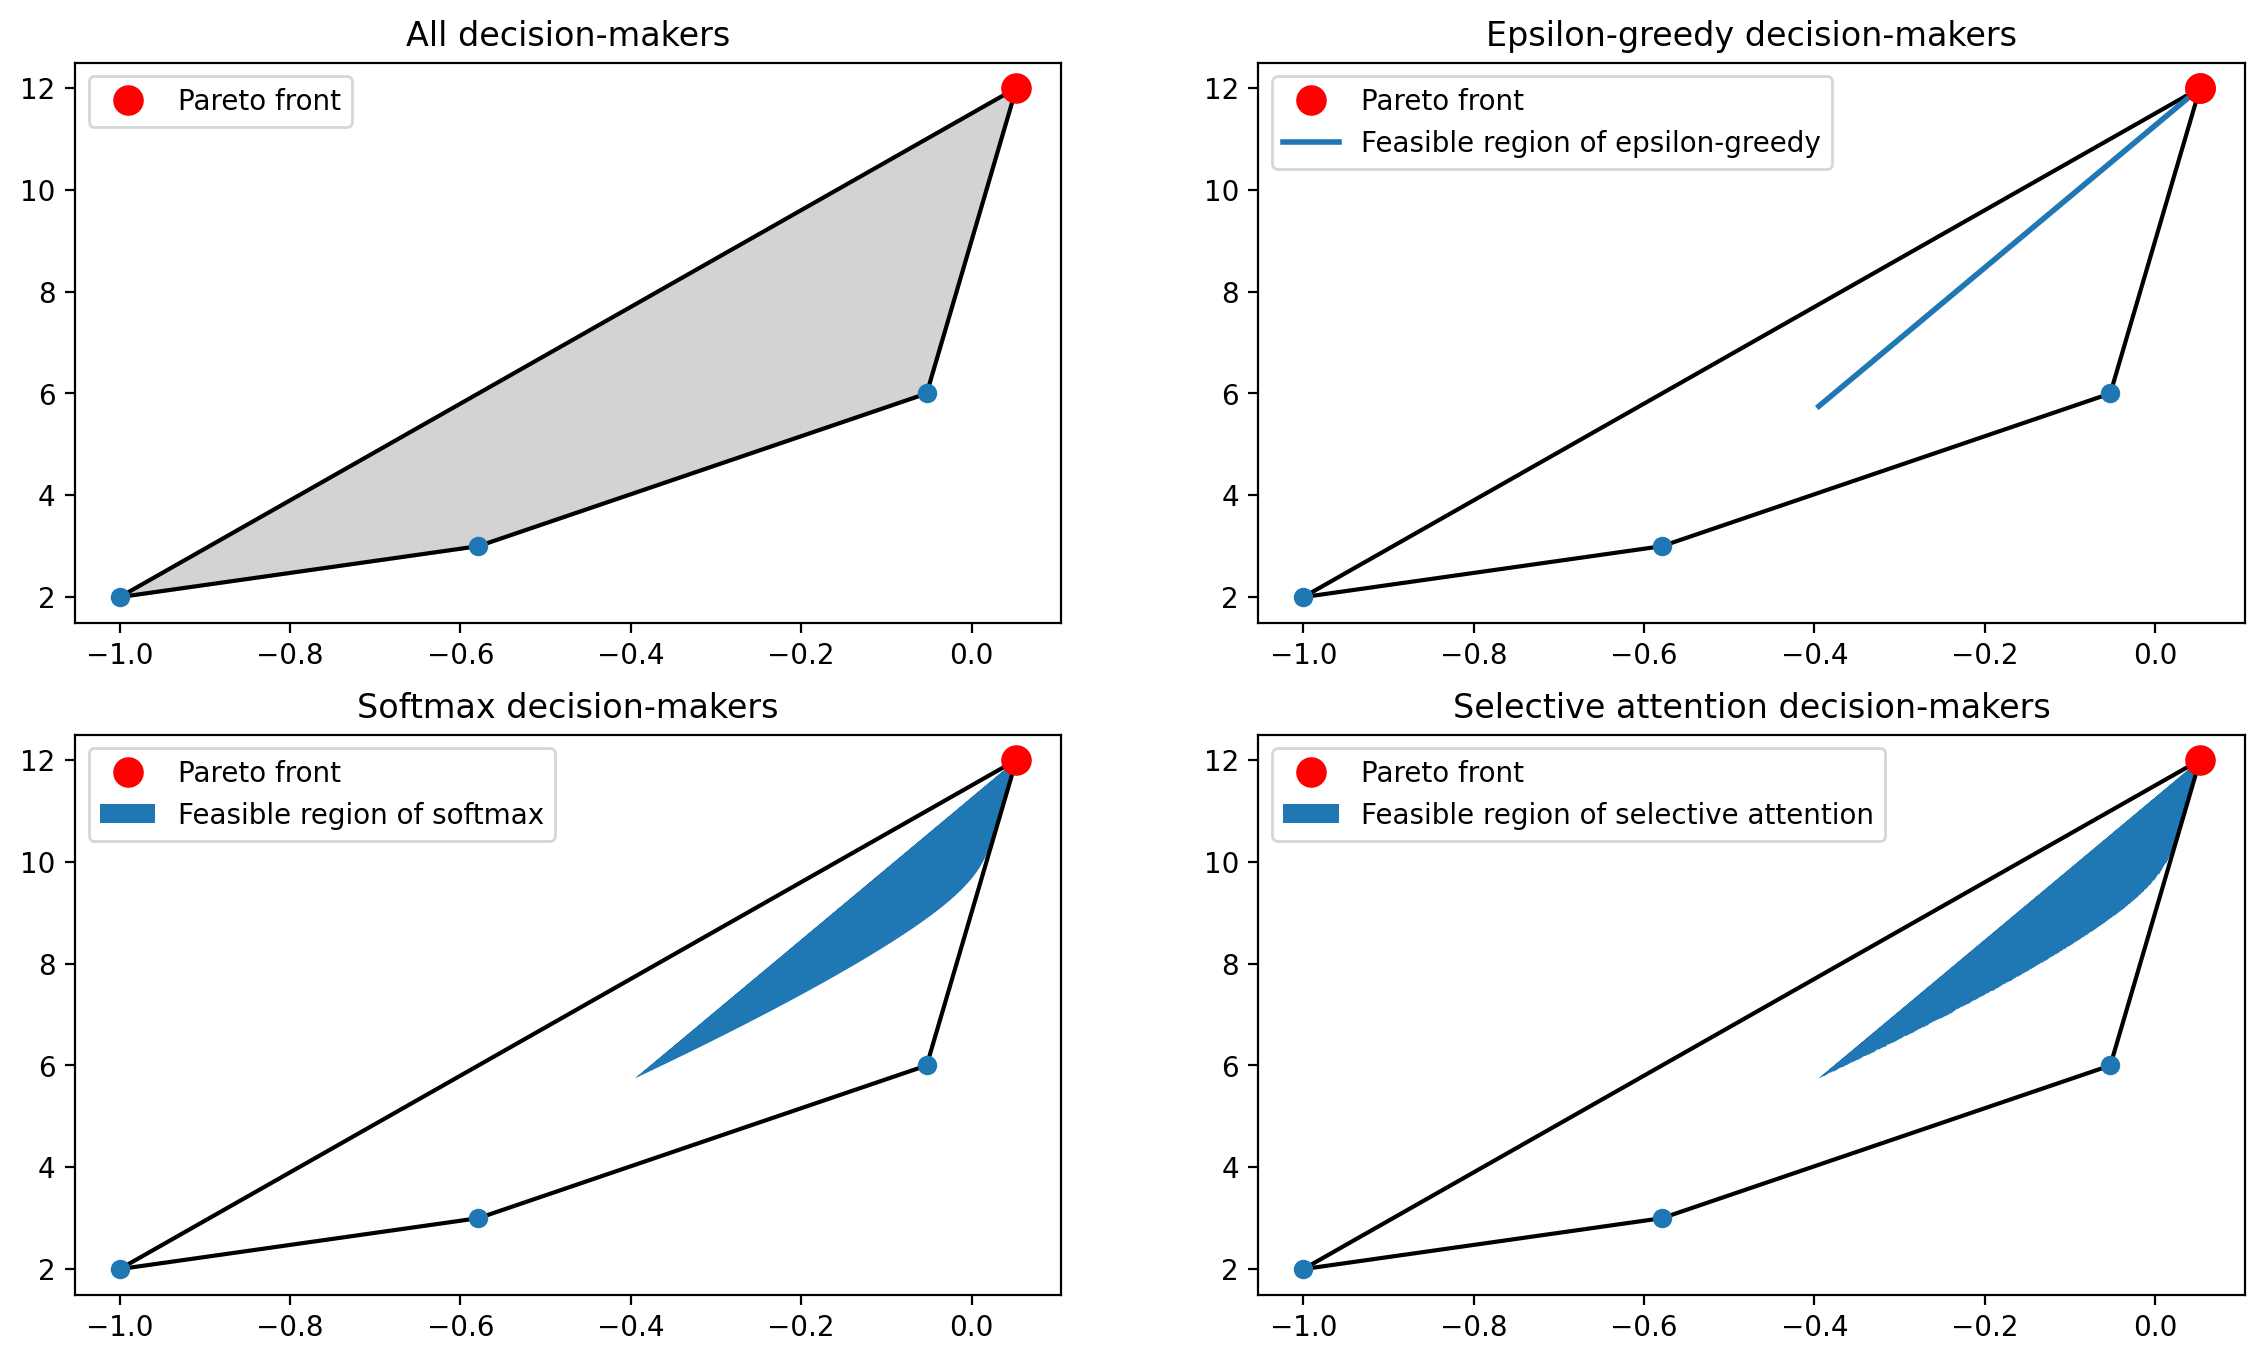

In [3]:
# Figures 6 in Chapter 4 
figure(figsize=(14, 8), dpi=200)
R,T = rotate(REWARDS,THREATS,math.pi/2)
#--------------plotting--------------------
#R = R/np.max(R)
T = T/np.max(-T)

# function to plot the AAC Task Feasible Space
def plotAAC():
    plt.plot([T[0], T[3]], [R[0], R[3]], color = 'black', label='_nolegend_')
    

    plt.plot(T,R, color = 'black', marker = 'o', markerfacecolor = '#1f77b4', markeredgecolor = '#1f77b4', label='_nolegend_')
    plt.plot(T[3],R[3], 'o', c = 'red', markersize = 10)
    #plt.legend(['Pareto Front'])
#-------An example of non-trivial Feasible Space-----------
plt.figure(1)
plt.subplot(2,2,1)
plotAAC()
plt.legend(['Pareto front'])
plt.title("All decision-makers")
x,y = T,R
y1 = y
y2 = [y[0]]
m = (y[3] - y[0])/(x[3] - x[0])
b = (y[0]*x[3] - y[3]*x[0])/(x[3] - x[0])

y2.append(m*x[1]+b)
y2.append(m*x[2]+b)
y2.append(y[3])
print(np.shape(y1), np.shape(y2))

plt.fill_between(x,y1,y2, color = 'lightgrey')
#------Epsilon Greedy Feasible Region---------------
plt.subplot(2,2,2)
plotAAC()
x,y = run(eps_greedy,R,T)
centroid =[np.mean(T), np.mean(R)]

plt.plot([centroid[0], T[3]], [centroid[1], R[3]],c='#1f77b4', linewidth = 2)
plt.plot(T[3],R[3], 'o', c = 'red', markersize = 10, label = '_nolegend_')
plt.title("Epsilon-greedy decision-makers")
plt.legend(['Pareto front', 'Feasible region of epsilon-greedy'])

#--------------Softmax Feasible Region--------------
plt.subplot(2,2,3)
plotAAC()

x,y = run(softmax,R,T)
centroid =[np.mean(T), np.mean(R)]

#-fil_between takes some work here---
X = np.hstack([x[0], x[-1]])
print(np.shape(X))
Y = np.hstack([y[0], y[-1]])
plt.fill(X,Y)
plt.title("Softmax decision-makers")
plt.legend(['Pareto front', 'Feasible region of softmax'])

#---------------------Selective Attention Feasible Region-----------------------
plt.subplot(2,2,4)
plotAAC()
x,y = run(selective_attention,R,T)
X = np.hstack([x[0], x[-1]])
print(np.shape(X))
Y = np.hstack([y[0], y[-1]])
plt.fill(X,Y)
plt.title("Selective attention decision-makers")
plt.legend(['Pareto front', 'Feasible region of selective attention'])

[-7.5 -6.5 -3.5  2.5]
(4,) (4,)


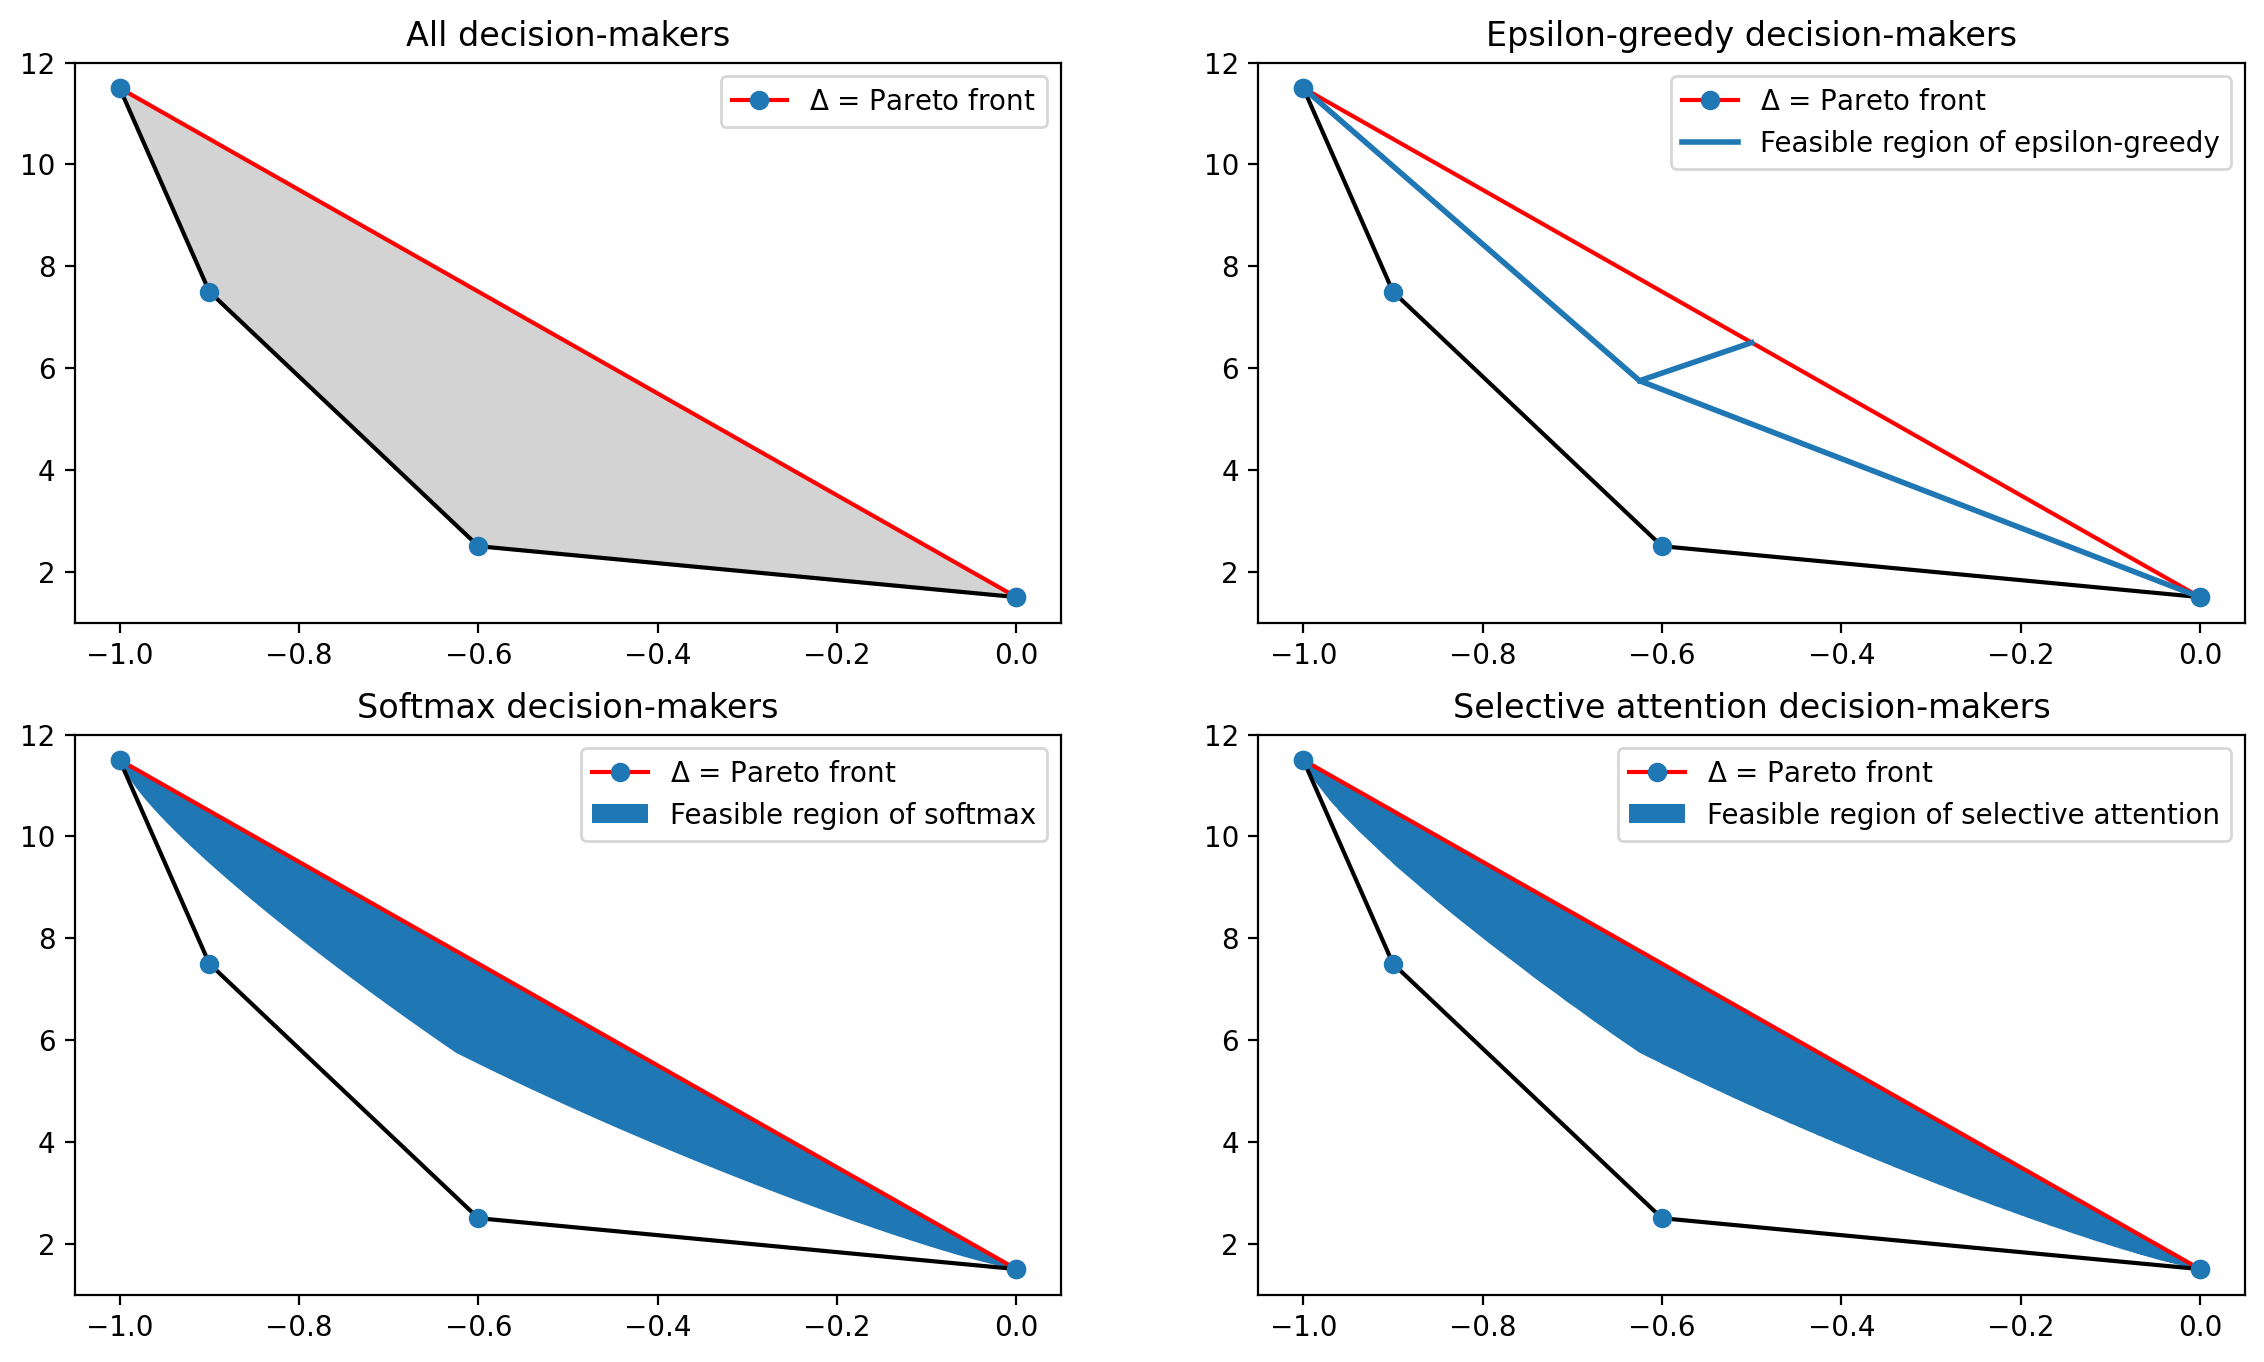

In [4]:
#Figure 7 of Chapter 4
figure(figsize=(14, 8), dpi=200)
R,T = rotate(REWARDS,THREATS,math.pi)
#--------------plotting--------------------
#R = R/np.max(R)
print(T)
T = (T-np.max(T))/(np.max(T)-np.min(T))
decision_makers = ['Whole AAC Feasible Space','Epsilon-greedy feasible region', 'Softmax feasible region', 'Selective-attention feasible region']
# function to plot the AAC Task Feasible Space
def plotAAC(index):
    plt.plot([T[0], T[3]], [R[0], R[3]], "-o", color = 'red', markerfacecolor = '#1f77b4', markeredgecolor = '#1f77b4', label = '_legend_' )
    plt.plot(T,R, "-o",color = 'black', markerfacecolor = '#1f77b4', markeredgecolor = '#1f77b4' , label = '_nolegend_')
    
# AAC Feasible Space
plt.subplot(2,2,1)
plotAAC(1)
plt.title("All decision-makers")
plt.legend(["$\Delta$ = Pareto front"])
x,y = T,R
y1 = y
y2 = [y[0]]
m = (y[3] - y[0])/(x[3] - x[0])
b = (y[0]*x[3] - y[3]*x[0])/(x[3] - x[0])

y2.append(m*x[1]+b)
y2.append(m*x[2]+b)
y2.append(y[3])
print(np.shape(y1), np.shape(y2))
plt.fill_between(x,y1,y2, color = 'lightgrey')
#------Epsilon Greedy Feasible Region---------------
plt.subplot(2,2,2)
plotAAC(2)
x,y = run(eps_greedy,R,T)
centroid =[np.mean(T), np.mean(R)]

plt.plot([T[0], centroid[0], T[3]], [R[0],centroid[1], R[3]],c='#1f77b4', linewidth = 2)
plt.plot([centroid[0], (T[0]+T[3])*0.5],[centroid[1], (R[0]+R[3])*0.5], c='#1f77b4', linewidth = 2)
plt.title("Epsilon-greedy decision-makers")
plt.legend(["$\Delta$ = Pareto front", "Feasible region of epsilon-greedy"])


#--------------Softmax Feasible Region--------------------------
plt.subplot(2,2,3)
plotAAC(3)

x,y = run(softmax,R,T)


#-fil_between takes some work here------------------------------
# order matters - that's why we need to flip
X = np.hstack([np.flip(x[0]), x[-1], T[0],T[3]])
Y = np.hstack([np.flip(y[0]), y[-1], R[0],R[3]])
plt.fill(X,Y)
plt.title("Softmax decision-makers")
plt.legend(["$\Delta$ = Pareto front", "Feasible region of softmax"])


#--------------Selective Attention Feasible Region--------------
plt.subplot(2,2,4)
plotAAC(3)

x,y = run(selective_attention,R,T)

#-----fil_between takes some work here---
# order matters - that's why we need to flip
X = np.hstack([np.flip(x[0]), x[-1], T[0],T[3]])
Y = np.hstack([np.flip(y[0]), y[-1], R[0],R[3]])
plt.fill(X,Y)

#---------------------------------------------------------------
plt.title("Selective attention decision-makers")
plt.legend(["$\Delta$ = Pareto front", "Feasible region of selective attention"])


[3.30234698 5.9506297  8.23235892 5.5146644 ] [  2.66357893  -0.49657907  -5.86255632 -11.30444354]
(4,) (4,)
m =  -8.076639126365858  b =  3.302346978440828
[2.54099306]
-0.18101871787038953 4.764369837797375 -2.398081733190338e-14


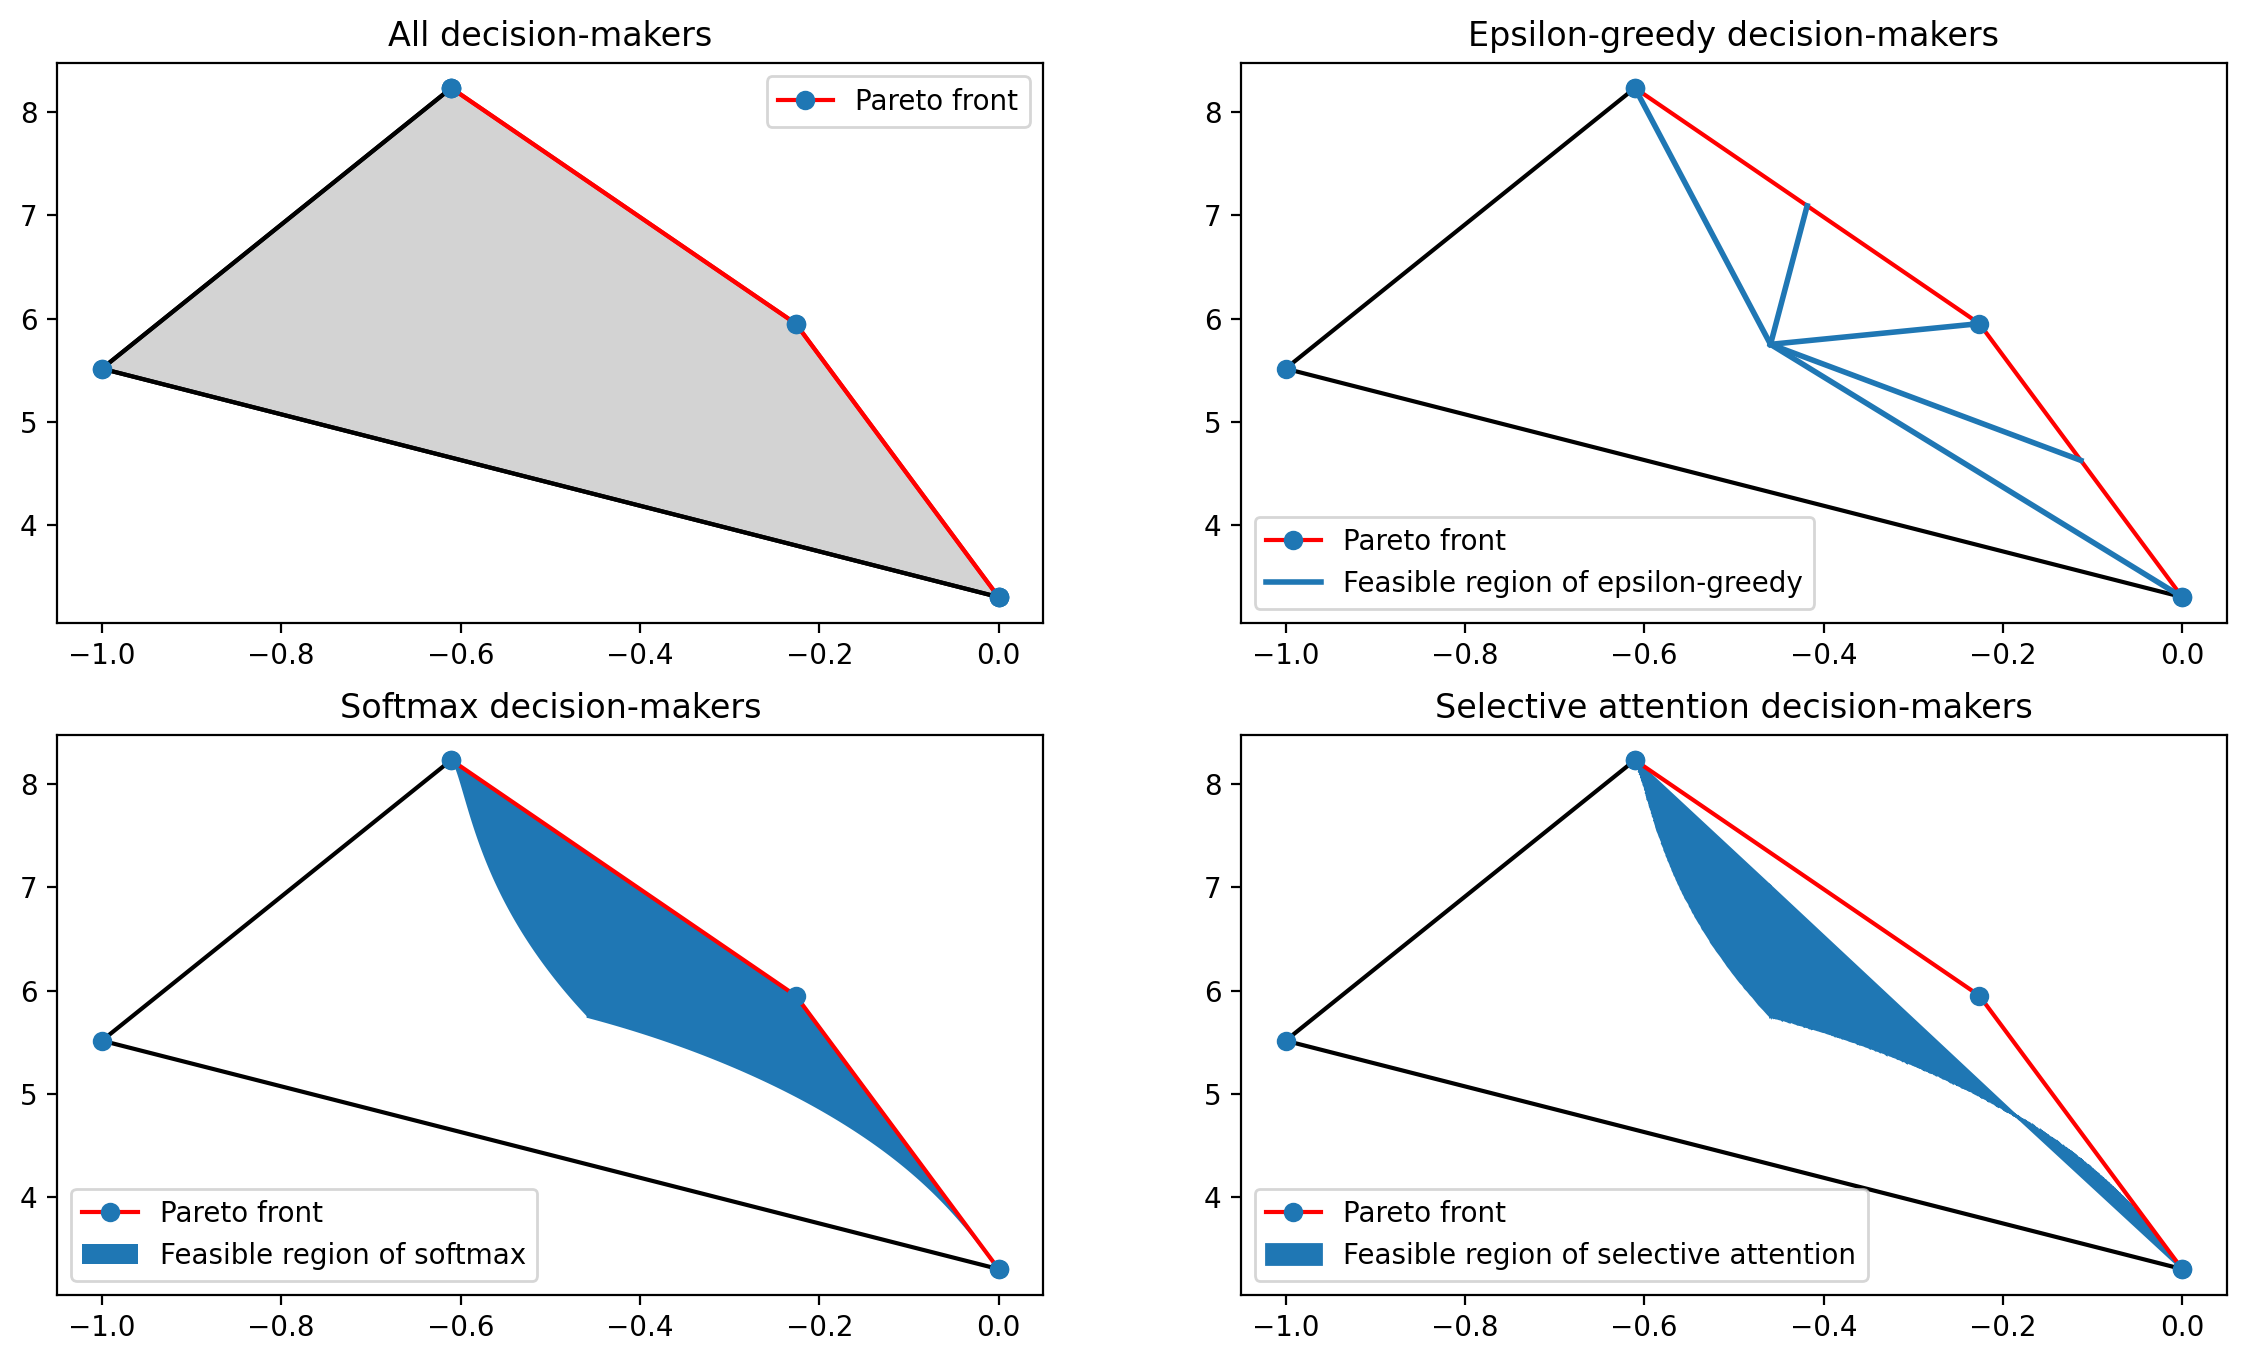

In [6]:
# Figure 8 of Chapter 4
from scipy.optimize import fsolve
figure(figsize=(14, 8), dpi=200)
R,T = rotate(REWARDS,THREATS,1.8*math.pi)
print(R,T)
# scale = [1, 1 ,1, 1]
# for i in range(4):
#     R[i]*= scale[i]
#     T[i]*= scale[i]

#R = R/np.max(R)
T = (T-np.max(T))/(np.max(T)-np.min(T))


#--------------plotting--------------------

decision_makers = ['Whole AAC Feasible Space','Epsilon-Greedy Feasible Region', 'Softmax Feasible Region', 'Selective-Attention Feasible Region']
# function to plot the AAC Task Feasible Space
def plotAAC(index):
    plt.plot([T[0], T[1], T[2]], [R[0], R[1], R[2]],"-o", color = 'red', markerfacecolor = '#1f77b4', markeredgecolor = '#1f77b4', label = '_legend_')
    plt.title("A non-trivial feasible region")
    plt.plot([T[0], T[3], T[2]],[R[0], R[3], R[2]], '-o', color = 'black', markerfacecolor = '#1f77b4', markeredgecolor = '#1f77b4', label = '_nolegend_')


# AAC Feasible Space
plt.subplot(2,2,1)
plotAAC(1)
x,y = run(softmax,R,T)

# AAC Feasible Space
plt.subplot(2,2,1)
plotAAC(1)
plt.title("All decision-makers")
plt.legend(["Pareto front"])
x,y = T,R
y1 = y
y2 = [y[0]]
m = (y[3] - y[0])/(x[3] - x[0])
b = (y[0]*x[3] - y[3]*x[0])/(x[3] - x[0])

y2.append(m*x[1]+b)
y2.append(m*x[2]+b)
y2.append(y[3])
print(np.shape(y1), np.shape(y2))
plt.fill_between(x,y1,y2, color = 'lightgrey')

# ------------this part here is plotting the w=0 and w=1 curves----------------
#-------------might be useful later so I left it here commented out------------
# plt.plot(x[0],y[0],"-o", color = 'black', markersize = 1)
# plt.annotate('w = 0', xy = (x[0,10], y[0,10]))
# plt.plot(x[-1], y[-1], '-o',color = 'black', markersize = 1)
# plt.annotate('w = 1', xy = (x[-1,10], y[-1,10]))

#------Epsilon Greedy Feasible Region---------------
plt.subplot(2,2,2)
plotAAC(2)
x,y = run(eps_greedy,R,T)
centroid =[np.mean(T), np.mean(R)]

plt.plot([T[0], centroid[0]], [R[0],centroid[1]],c='#1f77b4', linewidth = 2)
plt.plot([T[1], centroid[0]], [R[1],centroid[1]],c='#1f77b4', linewidth = 2)
plt.plot([T[2], centroid[0]], [R[2],centroid[1]],c='#1f77b4', linewidth = 2)
for i in range(2):
    plt.plot([centroid[0], (T[i]+T[i+1])*0.5],[centroid[1], (R[i]+R[i+1])*0.5], c='#1f77b4', linewidth = 2)
plt.title("Epsilon-greedy decision-makers")
plt.legend(['Pareto front', 'Feasible region of epsilon-greedy'])

#--------------Softmax Feasible Region--------------
plt.subplot(2,2,3)
plotAAC(3)

x,y = run(softmax,R,T)
centroid =[np.mean(T), np.mean(R)]

#-fil_between takes some work here---
X = np.hstack([T[2], T[1], x[-1]])
Y = np.hstack([R[2], R[1], y[-1]])
plt.fill(X,Y)
x1 = x[0]
x1 = x1[::-1]
y1 = y[0]
y1 = y1[::-1]
X = np.hstack([T[0], x1, T[1]])
Y = np.hstack([R[0], y1, R[1]])
plt.fill(X,Y, c='#1f77b4')
plt.title("Softmax decision-makers")
plt.legend(['Pareto front', 'Feasible region of softmax'])

#--------------Selective Attention Feasible Region--------------
# this is the trickiest one
# since fill command is split into three regions
# to make the filling smoothly

plt.subplot(2,2,4)
plotAAC(3)

x,y = run(selective_attention,R,T)
centroid =[np.mean(T), np.mean(R)]
for i in range(4):
    plt.plot(T[i], R[i], "-", color = 'black',  label = '_nolegend_')
    #plt.annotate(str(i), xy = (T[i]+0.4,R[i]))
# THIS GONNA TAKE A WHILE
# w = 0 intersects with the pure diagonal
m = (R[2] - R[0])/(T[2] - T[0])
b = R[0] - m*T[0] # y = mx + b is the pure diagonal equation now
print('m = ',  m, ' b = ', b)
def func(t):
    temp = T - np.max(T)
    exp = np.exp(t*temp)
    x_den = np.dot(exp.T,T)
    y_den = np.dot(exp.T,R)
    X = x_den/np.sum(exp)
    Y = y_den/np.sum(exp)
    return Y - m*X - b
tau_solved = fsolve(func, 0.2)

xx,yy = sa_solver(R,T,0,tau_solved)
print(tau_solved)
print(xx,yy, yy-m*xx-b)
#plt.plot([xx], [yy], "orange", markersize = 100)

x1 = np.hstack([x[-1], centroid[0]])
y1 = np.hstack([y[-1], m*centroid[0]+b])
#plt.plot(x1,y1,'o--')
plt.fill(x1,y1, c='#1f77b4', label = '_nolegend_' )

split = 250
x2 = np.hstack([centroid[0],x[0,0:split]])
y2 = np.hstack([m*centroid[0]+b, y[0,0:split]])
#plt.plot(x2,y2,'b--')
plt.fill(x2,y2, c='#1f77b4', label = '_nolegend_')

x3 = np.hstack([x[0,split-1:], T[0]])
y3 = np.hstack([y[0,split-1:], m*T[0]+b])
#plt.plot(x3,y3,'r--')
plt.fill(x3,y3, c='#1f77b4', label = '_legend_')
plt.title("Selective attention decision-makers")
plt.legend(["Pareto front", "Feasible region of selective attention"])
